# Kinopoisk

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
import os
from tqdm import tqdm_notebook

## Подготовка данных

In [4]:
reviews_path = Path('data/kinopoisk')

In [5]:
json_df = pd.read_json(reviews_path/'kinopoisk_reviews.json', lines=True)

In [6]:
json_df.head()

,filmId,numOfDislikes,numOfLikes,reviewBody,reviewTitle,status
0,5900,6,24,"Очень красивая фантастика, отлично снято, опер...",,neutral
1,782,18,34,"Мне думается, что у некоторых звёзд Голливуда ...",,good
2,54061,16,16,"Нервный парнишка, нервные взрослые, раздражени...",,neutral
3,13682,23,17,«Горец 2» - продолжение культовой саги о бессм...,,neutral
4,39634,9,10,"Для чего делали фильм, я думаю, сами авторы то...",,neutral


In [5]:
path = Path('models')

In [33]:
bs = 64

In [11]:
data = TextList.from_df(json_df, cols='reviewBody',
                        processor=[TokenizeProcessor(tokenizer=Tokenizer(lang="xx")), 
                                                     NumericalizeProcessor(min_freq=2, max_vocab=60000)]).\
                random_split_by_pct(.1).\
                label_for_lm().\
                databunch(bs=bs)

In [12]:
data.save(path / "kinopoisk_lm_data")

In [34]:
data = load_data(path, "kinopoisk_lm_data", bs)

In [13]:
data.show_batch()

idx,text
0,"xxmaj вот чего не хватает в фильме , так это xxunk рассказа , мифологии , ху из ху , так сказать :) ( как в xxmaj звездных войнах , например ) и откуда все эти xxunk и xxunk взялись . \r \n \r \n а какой звук , это просто потрясающе ! xxmaj полный эффект присутствия , хотя может это все зависит от кинотеатра . xxbos xxmaj нервный парнишка"
1,", эпоху войн , эпоху царей - xxunk . \r \n \r \n xxmaj фильм красиво и масштабно снят , что для фильма такого жанра очень важно . xxmaj бред xxmaj пит выглядит довольно убедительно в роли xxmaj xxunk . \r \n \r \n xxmaj по моему мнению - главный недостаток фильма это не выразительные массовые батальные сцены , битва греков с xxunk недостаточно яркая . xxmaj как"
2,"россии ) фильм xxmaj федерико xxmaj феллини . xxmaj когда несколько лет тому назад он был xxunk на фестивале итальянского кино в xxmaj москве - это стало настоящим подарком для публики . \r \n \r \n xxmaj веселая и грустная , авантюрная и бытовая история простых людей . xxmaj мошенники с xxunk , и с самими собой . xxmaj один из самых трогательных фильмов мэтра . xxbos я страстный"
3,\r \n \r \n < i > xxmaj бастер < / xxup i>. xxmaj хороший злодей – это либо когда хочется подойти к телевизору и сильно ударить этого негодяя по морде . xxmaj этот не вызвал ни малейших чувств . \r \n \r \n xxmaj сюжет - банальнее некуда . \r \n xxmaj шуток нет . \r \n xxmaj интересных сцен нет . \r \n \r
4,"которую xxunk придется собирать по крупицам на протяжении всего фильма , чтобы лишь в финале , окончательно определиться со своим выбором . xxmaj однако , самое интересное , что наравне с героем , тот же самый выбор предстоит сделать и самому зрителю . \r \n \r \n xxmaj окончательное решение xxmaj тэйлора является столь же xxunk , как и мораль обоих его « отцов » . xxmaj кто -"


In [17]:
learn = language_model_learner(data, arch=AWD_LSTM)

In [18]:
#learn = language_model_learner(data, arch=AWD_LSTM, pretrained_fnames=('lm_5_ep_lr2-3_5_stlr', 'itos'))


In [15]:
TEXT = "Вообще, приходя в себя"
N_WORDS = 40
N_SENTENCES = 2

In [16]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Вообще, приходя в себя , небольшая часть населения Северной столицы продолжает оставаться в Петербурге , но на первый взгляд , поэтому , несмотря на то , что в Петербурге и Петербурге им не много лет , которые находятся в
Вообще, приходя в себя , NASA фактически приняло решение начать подготовку к исследованию космического корабля « Союз РАССТРАИВАЕТ » , который должен был начаться в конце мая – начале июля . Таким образом , чтобы получить разрешение на полеты на


### Обучение модели

Перед тем как приступить к обучению языковой модели, мы должно найти оптимальный learning_rate (lr) - это гиперпараметр, который определяет с какой скоростью будет обучаться модель

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


На графике нам нужно выбрать наибольший LR такой, что Loss (функцию потерь) еще достаточно быстро уменьшается. Мы выберем 10e-2. 

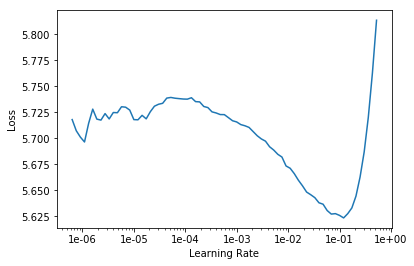

In [18]:
learn.recorder.plot(skip_end=15)

Так как часть слов в словаре новые и сеть про них ничего не знает, то мы начнем обучать "последний слой"

In [19]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.623338,4.057502,0.228571,29:25


Сохраняем модель

In [20]:
learn.save('kinopoisk_head')

In [22]:
learn.load('kinopoisk_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (44973 items)
x: LMTextList
xxbos xxmaj очень красивая фантастика , отлично снято , оператору особая благодарность , мастерам спецэффектов тоже xxunk поклон . xxmaj все качественно и необыкновенно ! о xxmaj вине xxmaj xxunk я вообще молчу :) восхищена , очень классно ! 
 
 
 
  xxmaj нет той привычной напыщенности и ' крутости ' , как в обыкновенных боевиках , он побеждает благодаря своей силе , стремлению выжить во что бы то ни стало . xxmaj вот чего не хватает в фильме , так это xxunk рассказа , мифологии , ху из ху , так сказать :) ( как в xxmaj звездных войнах , например ) и откуда все эти xxunk и xxunk взялись . 
 
 
 
  а какой звук , это просто потрясающе ! xxmaj полный эффект присутствия , хотя может это все зависит от кинотеатра .,xxbos xxmaj нервный парнишка , нервные взрослые , раздражения и xxunk друг другом и самим собой . 
 
 
 
  xxmaj безысходность и xxunk жизнью ( такой короткой ) выливается в трагический исход гл

Посмотрим как работает предсказание:

In [24]:
TEXT = "полный эффект присутствия"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

полный эффект присутствия в ' Сумерках ' не позволяет без спойлеров принять в расчет . Их читали подробно , назовем сценарий . Как выяснилось , все , что у меня есть в основе сценария , абсолютно . Их хоть
полный эффект присутствия в фильме ' Зеленая миля ' для детей в качестве , к сожалению , не добавляет фильму домохозяйки изюминки , которая , как мне кажется , была значительно лучше . Поэтому , это значит , что история о


Теперь мы "разморозим" все слои и продолжим обучение языковой модели

In [25]:
learn.unfreeze()

In [26]:
from fastai.callbacks import SaveModelCallback, ReduceLROnPlateauCallback

In [29]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8, 0.7), 
                    callbacks=[SaveModelCallback(learn, name='best_kinopoisk')])

epoch,train_loss,valid_loss,accuracy,time
0,4.374048,3.758804,0.300000,33:44
1,4.262966,3.546897,0.328571,33:48
2,4.226732,3.489769,0.371429,33:50
3,4.159681,3.341416,0.385714,33:52
4,4.098773,3.390381,0.371429,33:54
5,4.072806,3.288219,0.385714,33:53
6,4.043604,3.259739,0.371429,33:55
7,3.992717,3.264781,0.400000,33:54
8,3.968031,3.251725,0.371429,33:55
9,3.943636,3.248332,0.385714,33:54


Better model found at epoch 0 with val_loss value: 3.7588043212890625.
Better model found at epoch 1 with val_loss value: 3.5468966960906982.
Better model found at epoch 2 with val_loss value: 3.489769220352173.
Better model found at epoch 3 with val_loss value: 3.341416358947754.
Better model found at epoch 5 with val_loss value: 3.2882192134857178.
Better model found at epoch 6 with val_loss value: 3.2597389221191406.
Better model found at epoch 8 with val_loss value: 3.251725435256958.
Better model found at epoch 9 with val_loss value: 3.2483322620391846.


In [30]:
learn.save('kinopoisk_tuned')

In [21]:
learn.model_dir = ''

In [22]:
learn.load('kinopoisk_tuned');

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (44973 items)
x: LMTextList
xxbos xxmaj очень красивая фантастика , отлично снято , оператору особая благодарность , мастерам спецэффектов тоже xxunk поклон . xxmaj все качественно и необыкновенно ! о xxmaj вине xxmaj xxunk я вообще молчу :) восхищена , очень классно ! 
 
 
 
  xxmaj нет той привычной напыщенности и ' крутости ' , как в обыкновенных боевиках , он побеждает благодаря своей силе , стремлению выжить во что бы то ни стало . xxmaj вот чего не хватает в фильме , так это xxunk рассказа , мифологии , ху из ху , так сказать :) ( как в xxmaj звездных войнах , например ) и откуда все эти xxunk и xxunk взялись . 
 
 
 
  а какой звук , это просто потрясающе ! xxmaj полный эффект присутствия , хотя может это все зависит от кинотеатра .,xxbos xxmaj нервный парнишка , нервные взрослые , раздражения и xxunk друг другом и самим собой . 
 
 
 
  xxmaj безысходность и xxunk жизнью ( такой короткой ) выливается в трагический исход гл

In [23]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.978713,3.911488,0.338658,30:28


In [24]:
learn.save('kinopoisk_improved_1')

In [26]:
learn.load('kinopoisk_tuned');

In [28]:
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.997579,3.916836,0.337654,30:29


In [29]:
learn.save('kinopoisk_improved_2')

Сохраняем Encoder

In [32]:
learn.save_encoder('kinopoisk_tuned_enc')

In [33]:
TEXT = "полный эффект присутствия"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

полный эффект присутствия . Не зря же Питер Джексон на самом деле является режиссером этого фильма , но режиссер Питер Джексон , священник , которого я не видел после просмотра фильма , не смог меня удивить .
полный эффект присутствия . Фильм невероятно яркий , интригующий , не претендующий на звание шедевра , но , на мой взгляд , такой же забавный и линейный . Говоря откровенно , он оправдал все ожидания , и в первую очередь ,


Речь стала намного более связной!

In [35]:
TEXT = "фильм полностью оправдал"
N_WORDS = 90
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

 
 
  Отличный подбор актёров на главную роль . Весь фильм построен на диалогах : одни и те же . Очень понравился тот момент , когда Кристиан Бэйл играет Тома Харди . Кто же будет смотреть на Бэйла ? Он сыграл того самого полицейского , который играл в фильмах , но в целом сыграл в этом фильме не хуже самого Бэйла . Он настолько тираном , что даже не верится , что
 
 
 
 
  10 из 10 xxbos Картина повествует о предысторию , связанной с началом войны в Ираке , когда данный фильм стал классикой американского кинематографа . Картина «


In [36]:
TEXT = "могло быть и"
N_WORDS = 90
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

 
 
  Именно из - за Тоби Магуайра в фильме ' Человек -
 
 
  Но , несмотря на все плюсы , я не могу сказать , что остался доволен . Да , это не фильм ужасов , а скорее не о войне , а о войне . Это странная , страшная , жизненная драма . Но , боюсь , именно этот фильм о том , что такое война , что могут быть другие люди . а еще есть девушка , которую надо убить , чтобы она не любила и не желает заниматься любимым


In [37]:
TEXT = "самый настоящий провал"
N_WORDS = 60
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

 
 
  Начну с того , что фильм , конечно , не скучный , но и не новый . По правде , Marvel - это единственная , вина , которая может быть интересна мне в
самый настоящий провал этого фильма ! Если честно , не ожидал , что это очередная пародия на ту же ' Ночь в музее ' , но в последние годы таким фильмам не хватало одного из лучших фильмов , а на такой ' шедевр ' стоит сходить . По - моему , комиксы тут очень и очень хороши . Также


### Языковая модель

In [28]:
learn.load('kinopoisk_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (28067 items)
x: LMTextList
xxbos xxmaj xxunk xxunk блокаду изнутри .,xxbos xxmaj никогда у меня не будет " одного приложения для всего " . в топку эти xxunk xxunk .,xxbos xxmaj кури - и тебя не укусит злая собака , потому что ты xxunk , кури - и тебя не xxunk , так как ты xxunk xxunk xxunk громким xxunk , кури - и ты не умрешь от старости , просто не xxunk до нее . xxmaj дамы и господа курите насмерть ! ! !,xxbos xxmaj есть 3 типа людей : 
  xxmaj умные , которые делают все сразу . 
  xxmaj умные , которые откладывают на потом и доделывают . 
  и я ... сначала впадлу потом поздно,xxbos xxunk чет накрыло
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (3118 items)
x: LMTextList
xxbos xxrep 12 а xxrep 11 ! где кот ? xxrep 5 . xxunk xxrep 5 .,xxbos xxmaj забудьте о прошлом , живите настоящим думайте о будущем .,xxbos люблю очень xxunk,xxbos xxmaj xxunk xxmaj xxunk,xxbos xxmaj новая xxunk
y: LMLabelList
,,,,
Path: .;

Test: None, mode

In [109]:
TextList.split_by_list??

### Подготовим датасет для классификации

In [8]:
json_df.groupby('status')['filmId'].count()

status
bad         7511
good       33440
neutral     9019
Name: filmId, dtype: int64

In [9]:
bad_reviews = json_df[json_df.status=='bad']

In [10]:
good_reviews = json_df[json_df.status=='good'].sample(7511)

In [12]:
df_all = pd.concat((bad_reviews, good_reviews))

In [14]:
df_all = df_all.sample(frac=1).reset_index(drop=True)

In [16]:
df_all.shape

(15022, 6)

In [18]:
df_valid = df_all.iloc[:3750]

In [19]:
df_train = df_all.iloc[3750:]

In [27]:
df_valid.to_json(reviews_path/'valid_reviews.json', orient='records', lines=True)

In [30]:
df_train.to_json(reviews_path/'train_reviews.json', orient='records', lines=True)

In [31]:
df_all.to_json(reviews_path/'all_reviews.json', orient='records', lines=True)

In [27]:
df_valid.to_csv(reviews_path/'valid_reviews.csv', lines=True)

In [30]:
df_train.to_csv(reviews_path/'train_reviews.csv', orient='records', lines=True)

In [ ]:
TextList.from_csv()

### Переходим к классификации

In [10]:
json_df.head()

,filmId,numOfDislikes,numOfLikes,reviewBody,reviewTitle,status
0,5900,6,24,"Очень красивая фантастика, отлично снято, опер...",,neutral
1,782,18,34,"Мне думается, что у некоторых звёзд Голливуда ...",,good
2,54061,16,16,"Нервный парнишка, нервные взрослые, раздражени...",,neutral
3,13682,23,17,«Горец 2» - продолжение культовой саги о бессм...,,neutral
4,39634,9,10,"Для чего делали фильм, я думаю, сами авторы то...",,neutral


In [37]:
data.vocab.save(path/'kinopoisk_lm_vocab.pkl')

In [10]:
bs = 24

In [39]:
data_clas = (TextList.from_df(df_all, cols='reviewBody', vocab=data.vocab)
             .random_split_by_pct(.25)
             .label_from_df(cols='status')
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save(path/'kinopoisk_data_clas_clear.pkl')

In [11]:
data_clas = load_data(path, 'kinopoisk_data_clas_clear.pkl', bs)

Посмотрим как выглядят данные

In [40]:
data_clas.show_batch()

text,target
"xxbos xxup xxunk xxup девушка ( xxmaj xxunk ’s xxmaj girl ) \r \n xxrep 23 = \r \n xxmaj автор рецензии : xxmaj александр xxmaj xxunk \r \n xxmaj оценка : 10 / 10 \r \n \r \n ( xxmaj замечание : xxmaj написано под впечатлением от просмотра на языке оригинала . \r \n xxmaj версия с русским переводом ( xxunk ) , xxunk",good
"xxbos xxmaj или о пользе пиратов . в общем , как - то так , главное , что алкоголь - точно зло , а пираты - не такое явное . \r \n \r \n < b > xxmaj вместо xxunk : < / b > \r \n < xxup i>- а ты пойдешь на пиратов ? \r \n - xxmaj xxunk ! а ты ? \r \n",bad
"xxbos xxmaj прочитав анонс и взглянув на постер этого фильма очень легко можно xxunk . xxmaj штампы , которые люди привыкли произносить , услышав имя ' xxmaj джеки xxmaj чан ' так и бросаются в глаза - ' xxunk трюки ' , ' непревзойденная техника ' , ' знаменитый мастер ' , ' опасный кавалер ' - казалось бы , слова эти многое объясняют , но на деле ничего не",good
"xxbos < i > xxmaj злые люди бедной xxunk не дают украсть xxunk < / i > ( вместо xxunk ) \r \n \r \n xxmaj конечно , было интересно – что могут немцы снять про xxmaj сталинград ? xxmaj героический эпос – как - то , вроде , неловко . xxmaj хотя есть идея : показать xxunk к xxmaj xxunk нацистов людьми . xxmaj обычными , простыми ,",bad
"xxbos в сущности , ждать от фильма с участием < b > xxmaj майкла xxmaj мэдсена < / b > чего - то стоящего по меньшей мере наивно . xxmaj безусловно он снимался и в качественном кино , но основная масса его работ не выдерживает вообще никакой критики и ' < b > xxmaj xxunk xxmaj войны < / b > ' наглядный пример именно такого фильма . \r \n",bad


Заглянем внутрь

In [43]:
data.train_ds[6]

(Text xxbos xxmaj последнее творение dreamworks xxmaj animation xxunk как xxmaj xxunk 2 xxunk xxmaj xxunk xxmaj xxunk . xxmaj плюс обещали то ли постебаться над , то ли спародировать фильмы про итальянскую мафию . xxmaj по началу кажется , что все очень хорошо : диалог между xxmaj робертом xxmaj де xxmaj ниро и xxmaj мартином xxmaj скорсезе рассмешит любого , кто смотрел хотя бы один фильм о xxunk мафии ; куча ссылок на xxmaj славные xxmaj парни , xxmaj крестного xxmaj отца и xxmaj клан xxmaj сопрано ; прикольный подводный xxmaj нью - xxmaj йорк ; персонажи , в которых очень легко узнать голливудских звезд ; милый саундтрек в стиле xxunk 
  
  
  
   а уж когда погибает сынишка местного крестного папы , а xxmaj оскар объявляет себя xxmaj xxunk акул , думаешь , что вот сейчас все и начнется , сейчас ребята xxunk . xxup но к середине фильма начинаешь поглядывать на часы , а к концу становиться откровенно скучно . xxmaj хорошая идея и отличная завязка умирают к концу фильма . в итоге у со

But the underlying data is all numbers

Посмотрим как выглядят данные

In [8]:
data_clas.train_ds[6][0].data[:10]

array([   2,    5,   13, 2434,    9,   16,   11,  121, 3743,    5])

In [10]:
data_clas = load_data(path, 'kinopoisk_data_clas.pkl', bs=bs)

А теперь создадим классификатор

In [12]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.path = path
learn.model_dir = ''
learn.load_encoder('kinopoisk_tuned_enc')

### Начинаем магию

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


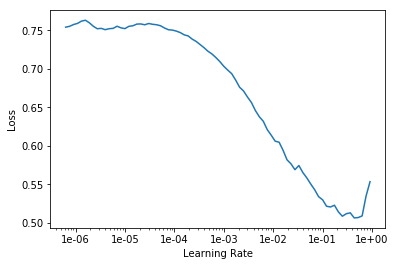

In [49]:
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(1, 4e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.296268,0.220915,0.917976,03:56


In [51]:
learn.save('kp_first')

In [52]:
learn.load('kp_first');

А теперь мы продолжаем размораживать слои, обучая их "по очереди", начиная с конца.

Мы не хотим сразу разрушить хрупкую структуру Encoder-a, который был обучен на предыдущем шаге.

In [53]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(3e-2/(2.6**4),3e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.184148,0.117084,0.958722,04:16


In [54]:
learn.save('kp_second')

In [55]:
learn.load('kp_second');

In [56]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.141272,0.106738,0.960053,06:24


In [57]:
learn.save('kp_third')

In [33]:
learn.load('kp_third');

In [31]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.111156,0.106131,0.958189,08:03


In [32]:
learn.save('kp_clas_tuned_2')

In [29]:
learn.save('kp_clas_tuned')

In [ ]:
learn.load('kp_clas_tuned')

Мы натренировали нашу сеть, которая с высокой точностью определяет тональность отзыва

Давайте проверим ее на случайном отызыве с кинопоиска

In [15]:
learn.predict('''
«Балканский рубеж» в некотором роде уникальный фильм для нашего синематографа последнего времени. И вот почему, с одной стороны мы снимаем по лекалам телефильмов о доблестном спецназе кино, которое при прочих равных прошло бы более или менее не замеченным, а с другой стороны обозначаем проблему сосуществования народов и этнических войн на территории бывшей Югославии. К данной теме я вообще не равнодушен и было интересно взглянуть, как отечественный режиссер покажет эти моменты. И получилось совсем не плохо, по крайней мере, у меня не возникает чувства непонимания, что происходило в Боснии и Косово. Да, широкими мазками обозначена проблема, зато доходчиво донесено, что испытывали простые люди при развале страны. 

После конфликта во взаимодействии с силами НАТО, члены разведовательно — диверсионной группы оказываются в непростой ситуации и вынуждены остаться вне пределов России. Каждый устраивается по своему в новой жизни и старается выжить. Но изменение вектора политической обстановки вновь делает их востребованными Отечеством. Надо занять и удержать аэропорт Приштины в Косово, до подхода российских миротворцев. Захват и удержание показаны в добротной манере отечественных сериалов, останавливаться на этом не буду, меня больше порадовали второстепенные линии сюжета. Возможно, сотрудничество с сербами сделали эти линии проникновенными с чисто человеческого восприятия. Это и драма в роддоме при налетах НАТО, и непростые отношения косоваров и сербов на примере полицейского поста в Косово, и этническо — конфессиональные расстрелы, и напряжение до срывов медработников от вида пострадавших — говорят война все спишет, это так. Только вот рубцов и ран в душах людей не излечит даже время, боль и горечь потерь близких и друзей долго будет жить в памяти. 

Переплетение реальных фактов и художественного вымысла неплохо сочеталось в этой ленте — марш-бросок на Приштину десантников удачно дополнил бой группы Бека, восторги сербов на кадрах хроники и киношные смотрелись органично. Что касается политических перипетий, то это дело грязное и идеологический контекст можно и пропустить при просмотре, хотя ничего нереального в показанном я не увидел. Порадовали показанные будни десантников, под «Сектор газа» смотрелось реалистично, вполне реальное развлечение для отвлечения от повседневной рутины.

Актеры сыграли в целом нормально и наши и сербские, из наших мне понравились Куркова, Полухин и Марин, из сербов Гойко Митич, Бикович и Родойичич. Специфический юмор только усилил игру актеров. Кустурица в концовке тоже смотрелся к месту. В целом, не проявив чудес актерского мастерства все смотрелись не плохо. 

Минусы конечно есть и довольно жирные, в основном связаны с навязыванием определенного идеологического подтекста, и увы, незнанием особенностей службы в войсках специального назначения. Но в целом фильм они не уродуют, поэтому смело отношу его к положительным моментам нашего кинопроката.
''')

(Category good, tensor(1), tensor([0.3057, 0.6943]))

In [16]:
learn.predict('''
Пусть видят, кто против них (с)

В конце 90-ых, во время очередного конфликта между сербами и албанцами, российская спецгруппа, находящаяся на территории Югославии, получает приказ захватить местный аэропорт и удержать его до прихода наших миротворцев.

Режиссер «Танцев насмерть» и «Спирали», посредственных, никому ненужных картин, Андрей Волгин на западе давно бы оказался у разбитого корыта и пошел бы на прорыв, получив последний шанс или вошел бы в какую-нибудь когорту создателей сериалов, где ты просто один из тех, кто визуализирует чужие идеи. У нас же все совершенно по-другому произошло… Волгин получил большой бюджет, материал и не самых последних актеров, и что же он из этого смастерил? Все самое наипростейшее… Мотивы героев, как и предсказуемость сюжетных ходов и выпрыгивания спецэффектов из-за ушла — все это уже миллион раз использованные другими ходы, причем и реализованные сверхстандартно и стерильно. Ведь если у тебя есть антагонист, то кроме как дать ему нож и возможность оправдать рейтинг 16+ — единственный вариант продемонстрировать его характер и жестокость. Так же и с другими героями, один поет, другой постоянно про пенсию говорит, третий хочет денег, а узбечка заглянула на проект в поисках мужика, так и работают. А зрителям еще нужно разбираться причем тут НАТО, кто виноват и что делать, в общем не считая плохих дорог здесь есть все классические вопросы, волнующие русских на протяжении веков.

По какой-то совершенно непонятной причине главную роль в «Балканском рубеже» исполнил Антон Пампушный («Защитники») — парень, конечно, колоритный, но с одной эмоцией на лице на любое происшествие и действие в его (их) сторону. Странно видеть таким потерянным Милоша Биковича («Лед»), у него здесь ключевая драматическая роль, но он так все это преподносит, что хочется снять ему скальп ничуть не меньше, чем террористам, которые гоняются за ним. Красивую Милену Радулович («Однажды летней ночью») при любой возможности раздевают, а героиня Равшаны Курковой («Без границ») получилась не только крутой, но еще и с юморком. Одного из самых запоминающихся бойцов с нашей стороны сыграл Сергей Марин («Анна-детективъ»), его неоднозначности и крутости, могли бы позавидовать и заграничные коллеги. Для увесистости в фильм влились: Гоша Куценко («Параграф 78»), которому очень нравится собирать себе отряды, любимейший югослав старшего поколения Гойко Митич («Апачи») и вечный Эмир Кустурица («Время цыган»). 

Картина «Балканских рубеж» очевидно снята явно из хороших побуждений и желания сделать, что-то свое на уровне Бэя и его «13 часов». Главные герои — такие наши Джеймсы Бонды без фантастической составляющей. Но вот снят «Балканский рубеж» самым скучным и потребительским образом: с кучей слоу-мо, увидев его количество даже создатели «Т-34» тихо стоят и покуривать в сторонке, хотя попытку сыграть в масштаб и серьезность можно и зачесть. Правда дешевые спецэффекты и длиннющие диалоги с попыткой хоть как-то раскрыть героев портят этот и так слишком затянутый фильм с нелогичным кастингом и музыкой, которая убаюкивает зрителей постоянно повторяющимся мотивом.''')

(Category bad, tensor(0), tensor([0.9772, 0.0228]))

In [17]:
learn.predict('Очень хороший фильм')

(Category good, tensor(1), tensor([0.0107, 0.9893]))

In [19]:
learn.predict('Не очень хороший фильм')

(Category good, tensor(1), tensor([0.1069, 0.8931]))

In [26]:
learn.predict('Почему то мне кажется, что фильм далек от идеала. Я бы не советовал его смотреть')

(Category bad, tensor(0), tensor([0.8909, 0.1091]))

In [19]:
learn.predict("Фильм очень не очень. Могло бы быть и лучше. Ужасный фильм")

(Category neutral, tensor(2), tensor([0.0170, 0.1889, 0.7942]))

In [75]:
learn.predict("Лучший фильм, который я когда-либо смотрел!")

(Category good, tensor(1), tensor([0.0327, 0.9673]))

In [87]:
learn.predict("Это худший фильм, который я когда-либо смотрел. Такие дела. Хотя может быть и стоит посмотреть фанатам")

(Category bad, tensor(0), tensor([0.6440, 0.3560]))

## Интерпритируем результаты работы

In [36]:
interp = ClassificationInterpretation.from_learner(learn)

In [37]:
losses,idxs = interp.top_losses()

len(data_clas.valid_ds)==len(losses)==len(idxs)

True

In [38]:
interp.most_confused()

[('bad', 'good', 81), ('good', 'bad', 69)]

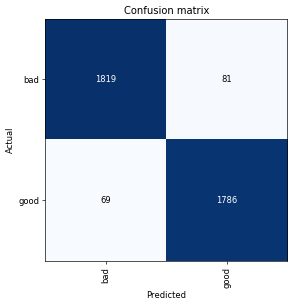

In [39]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

,0
0,(xxbos xxmaj фильм и мультипликационные эффект...


In [ ]:
interp.data.valid_ds[idxs].to_df

In [74]:
pd.DataFrame([interp.probs.tolist(), interp.y_true, losses])

,0,1,2,3,4,5,6,7,8,9,...,3745,3746,3747,3748,3749,3750,3751,3752,3753,3754
0,"[0.9794573783874512, 0.02054254710674286]","[0.08032911270856857, 0.9196708798408508]","[0.9989113807678223, 0.0010885943192988634]","[0.9978896975517273, 0.002110276138409972]","[0.9921839833259583, 0.007816040888428688]","[0.9583169221878052, 0.04168303310871124]","[0.03597991541028023, 0.9640201330184937]","[0.0012912378879263997, 0.9987087249755859]","[0.007498104125261307, 0.9925018548965454]","[0.9931135773658752, 0.006886401679366827]",...,"[0.0004108767316211015, 0.9995891451835632]","[0.941908061504364, 0.058091964572668076]","[0.9941375255584717, 0.005862508900463581]","[0.0020676208660006523, 0.9979324340820312]","[0.22289299964904785, 0.7771070599555969]","[0.019873032346367836, 0.9801269769668579]","[0.9846291542053223, 0.0153708690777421]","[0.9894140958786011, 0.010585915297269821]","[0.07813524454832077, 0.9218647480010986]","[9.817669342737645e-05, 0.9999017715454102]"
1,tensor(0),tensor(1),tensor(0),tensor(0),tensor(0),tensor(0),tensor(1),tensor(1),tensor(1),tensor(0),...,tensor(1),tensor(0),tensor(0),tensor(1),tensor(1),tensor(1),tensor(0),tensor(0),tensor(1),tensor(1)
2,tensor(6.0022),tensor(5.9901),tensor(5.7649),tensor(5.6648),tensor(5.5806),tensor(5.5272),tensor(5.2282),tensor(5.1292),tensor(3.6016),tensor(3.4851),...,tensor(8.5831e-05),tensor(7.9155e-05),tensor(6.5327e-05),tensor(6.2466e-05),tensor(5.9128e-05),tensor(5.7220e-05),tensor(5.6744e-05),tensor(4.6730e-05),tensor(4.3392e-05),tensor(-0.)


In [41]:
interp.pred_class

tensor([1, 1, 0,  ..., 1, 1, 1])

In [40]:
interp.y_true

tensor([2, 1, 0,  ..., 2, 1, 1])

In [42]:
idxs_sample = idxs[:10]

## Предыдущий тип

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

In [22]:
losses,idxs = interp.top_losses()

len(data_clas.valid_ds)==len(losses)==len(idxs)

True

In [26]:
interp.most_confused()

[('neutral', 'good', 996),
 ('bad', 'neutral', 441),
 ('good', 'neutral', 222),
 ('neutral', 'bad', 206),
 ('bad', 'good', 114),
 ('good', 'bad', 32)]

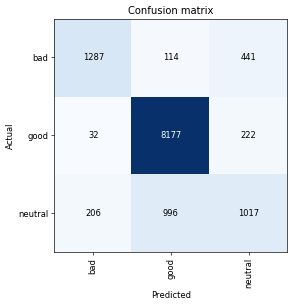

In [25]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [33]:
top_loss = interp.data.valid_ds[idxs[:10]]

In [41]:
interp.pred_class

tensor([1, 1, 0,  ..., 1, 1, 1])

In [40]:
interp.y_true

tensor([2, 1, 0,  ..., 2, 1, 1])

In [42]:
idxs_sample = idxs[:10]

In [45]:
pd.DataFrame([interp.data.valid_ds[idxs_sample].x, interp.pred_class[idxs_sample]])

,0
0,(xxbos < i > xxmaj за что все дети и взрослые ...
1,"[tensor(1), tensor(1), tensor(1), tensor(1), t..."


In [43]:
interp.data.valid_ds[idxs_sample].x

TextList (10 items)
xxbos < i > xxmaj за что все дети и взрослые любят сказки , так это за счастливый , добрый конец . xxmaj конец xxunk . xxmaj чем - то все обязательно закончится , но любителей , читателей , xxunk сказок как всегда в концовке ожидает счастье , дружба и любовь . < xxunk колец ' < / b > несмотря на устрашающих не только детей орков и прочую нечисть является тоже сказкой , правда , более взрослой нежели ' xxunk - лебеди ' , ' xxmaj маша и медведь ' . xxmaj вот и этой сказке пришла пора проститься с нами , но перед тем , как она с нами это сделает , она подарит нам неописуемой красоты более xxunk зрелище , которое останется в памяти навсегда и подарит ... веру и надежду в новую трилогию ! < / i > 
 
 
 
  xxmaj что - то расписывать цельное , в общих чертах , искать глубокий смысл или xxunk задумку режиссера в части третьей громадной саги , которая и создавалась - то одновременно - считаю делом лишним . xxmaj ведь трилогия < xxunk колец ' < / b > есть не что иное как един

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [ ]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [ ]:
path = untar_data(URLs.IMDB)

In [ ]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [ ]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [ ]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love",pos
"xxbos xxmaj here are the matches . . . ( adv . = advantage ) \n\n xxmaj the xxmaj warriors ( xxmaj ultimate xxmaj warrior , xxmaj texas xxmaj tornado and xxmaj legion of xxmaj doom ) v xxmaj the xxmaj perfect xxmaj team ( xxmaj mr xxmaj perfect , xxmaj ax , xxmaj smash and xxmaj crush of xxmaj demolition ) : xxmaj ax is the first to go",neg
"xxbos i felt duty bound to watch the 1983 xxmaj timothy xxmaj dalton / xxmaj zelah xxmaj clarke adaptation of "" xxmaj jane xxmaj eyre , "" because i 'd just written an article about the 2006 xxup bbc "" xxmaj jane xxmaj eyre "" for xxunk . \n\n xxmaj so , i approached watching this the way i 'd approach doing homework . \n\n i was irritated at first",pos
"xxbos xxmaj no , this is n't a sequel to the fabulous xxup ova series , but rather a remake of the events that occurred after the death of xxmaj xxunk ( and the disappearance of xxmaj woodchuck ) . xxmaj it is also more accurate to the novels that inspired this wonderful series , which is why characters ( namely xxmaj orson and xxmaj xxunk ) are xxunk ,",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.310078,0.197204,0.926960


In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.255913,0.169186,0.937800


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.223174,0.165679,0.939600


In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.240424,0.155204,0.943160
2,0.217462,0.153421,0.943960


In [ ]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([7.5928e-04, 9.9924e-01]))